# Machine_Learning_untuk_Predict_NBA_Players_Shot_Made

## 1. Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.ensemble import BaggingClassifier

## 2. Data Loading

In [2]:
df = pd.read_csv('NBA_Shots _2024.csv')
df

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11/03/2023,22300003,...,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.45,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11/03/2023,22300003,...,Above the Break 3,Center,C,24+ ft.,1.5,30.55,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11/03/2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.55,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11/03/2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.85,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11/03/2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,0.0,6.25,1,1,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218696,2024,2023-24,1610612737,Atlanta Hawks,203992,Bogdan Bogdanovic,G,SG,12/08/2023,22301218,...,Above the Break 3,Left Side Center,LC,24+ ft.,11.9,29.85,27,4,0,48
218697,2024,2023-24,1610612737,Atlanta Hawks,203991,Clint Capela,C,C,12/08/2023,22301218,...,In The Paint (Non-RA),Center,C,8-16 ft.,1.6,14.25,9,4,0,45
218698,2024,2023-24,1610612737,Atlanta Hawks,203991,Clint Capela,C,C,12/08/2023,22301218,...,In The Paint (Non-RA),Center,C,Less Than 8 ft.,0.6,9.75,4,4,0,44
218699,2024,2023-24,1610612737,Atlanta Hawks,1627749,Dejounte Murray,G,SG,12/08/2023,22301218,...,Above the Break 3,Center,C,24+ ft.,-1.7,34.55,29,4,0,37


In [3]:
# Data Eksplorasi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        218701 non-null  int64  
 1   SEASON_2        218701 non-null  object 
 2   TEAM_ID         218701 non-null  int64  
 3   TEAM_NAME       218701 non-null  object 
 4   PLAYER_ID       218701 non-null  int64  
 5   PLAYER_NAME     218701 non-null  object 
 6   POSITION_GROUP  218701 non-null  object 
 7   POSITION        218701 non-null  object 
 8   GAME_DATE       218701 non-null  object 
 9   GAME_ID         218701 non-null  int64  
 10  HOME_TEAM       218701 non-null  object 
 11  AWAY_TEAM       218701 non-null  object 
 12  EVENT_TYPE      218701 non-null  object 
 13  SHOT_MADE       218701 non-null  bool   
 14  ACTION_TYPE     218701 non-null  object 
 15  SHOT_TYPE       218701 non-null  object 
 16  BASIC_ZONE      218701 non-null  object 
 17  ZONE_NAME 

Dari hasil eksplorasi kita tidak menemukan adanya missing value tetapi ada type data yang tidak sesuai dengan kolomnya seperti SHOT_TYPE bertipe string saya akan merubah tipenya menjadi int, GAME_DATE harusnya bertipe date and time, dan juga kolom LOC_Y harusnya bertipe float, lalu saya juga akan merubah naming setiap kolom menjadi huruf kecil

In [4]:
# merubah nama kolom
df.columns = df.columns.str.lower()

In [5]:
# Checking value dari kolom shot_type
df['shot_type'].value_counts()

shot_type
2PT Field Goal    132346
3PT Field Goal     86355
Name: count, dtype: int64

Saya akan merubah valuenya dari 2PT Field Goal menjadi 2 dan 3PT Field Goal menjadi 3

In [6]:
# Merubah Value dalam kolom shot_type
df['shot_type'] = df['shot_type'].apply(lambda x: 3 if x == '3PT Field Goal' else 2)


In [7]:
df[df['loc_y'] == '11.500.000.000.000.000']

,season_1,season_2,team_id,team_name,player_id,player_name,position_group,position,game_date,game_id,...,basic_zone,zone_name,zone_abb,zone_range,loc_x,loc_y,shot_distance,quarter,mins_left,secs_left
976,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11/12/2023,22300178,...,Left Corner 3,Left Side,L,24+ ft.,22.4,11.500.000.000.000.000,22,3,5,56
56742,2024,2023-24,1610612755,Philadelphia 76ers,200768,Kyle Lowry,G,PG,03/05/2024,22300887,...,Left Corner 3,Left Side,L,24+ ft.,23.2,11.500.000.000.000.000,23,1,9,45
135827,2024,2023-24,1610612754,Indiana Pacers,204456,T.J. McConnell,G,PG,03/03/2024,22300877,...,Mid-Range,Right Side,R,8-16 ft.,-11.0,11.500.000.000.000.000,11,2,11,44
198820,2024,2023-24,1610612751,Brooklyn Nets,1629661,Cameron Johnson,F,PF,12-23-2023,22300394,...,Left Corner 3,Left Side,L,24+ ft.,22.2,11.500.000.000.000.000,22,2,4,32
199778,2024,2023-24,1610612751,Brooklyn Nets,1630560,Cam Thomas,G,SG,01-15-2024,22300562,...,Left Corner 3,Left Side,L,24+ ft.,22.9,11.500.000.000.000.000,23,4,7,52
206516,2024,2023-24,1610612738,Boston Celtics,1628401,Derrick White,G,SG,01/02/2024,22300462,...,Left Corner 3,Left Side,L,24+ ft.,23.0,11.500.000.000.000.000,23,4,0,41


Ternyata terdapat error data yang memiliki nilai loc_y yang tinggi, sepertinya ini terjadi karena error daat data loading yang seharusnya valuenya menjadi 11.5 saya akan memperbaikinya

In [8]:
# Mengambil 2 angka desimal
df['loc_y'] = df['loc_y'].str.extract(r'(\d+\.\d{2})').astype(float)


In [9]:
# pengecekan value yang nilainya diata 500
df[df['loc_y'] > 500]

,season_1,season_2,team_id,team_name,player_id,player_name,position_group,position,game_date,game_id,...,basic_zone,zone_name,zone_abb,zone_range,loc_x,loc_y,shot_distance,quarter,mins_left,secs_left


In [10]:
# merubah tipa data game_date menjadi date and time
df['game_date'] = pd.to_datetime(df['game_date'], format='mixed', dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   season_1        218701 non-null  int64         
 1   season_2        218701 non-null  object        
 2   team_id         218701 non-null  int64         
 3   team_name       218701 non-null  object        
 4   player_id       218701 non-null  int64         
 5   player_name     218701 non-null  object        
 6   position_group  218701 non-null  object        
 7   position        218701 non-null  object        
 8   game_date       218701 non-null  datetime64[ns]
 9   game_id         218701 non-null  int64         
 10  home_team       218701 non-null  object        
 11  away_team       218701 non-null  object        
 12  event_type      218701 non-null  object        
 13  shot_made       218701 non-null  bool          
 14  action_type     218701 non-null  obj

## 3. Exploratory Data Analysis (EDA)

### A. Stephen curry paling banyak mencetak 3pt atau 2 pt, dan dimanakah posisi terbaik dia dalam mencetak point?

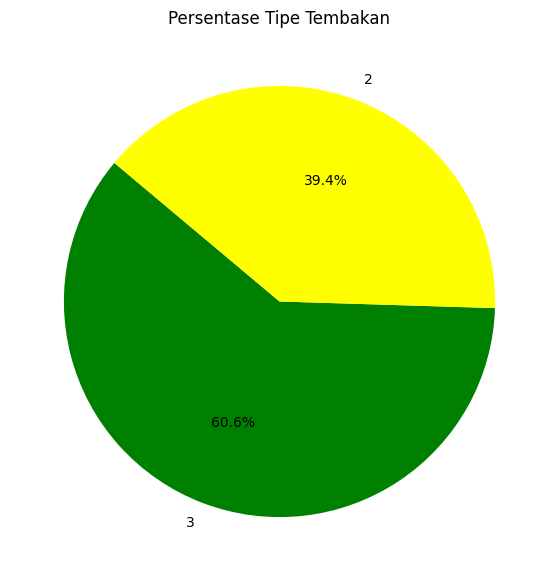

In [11]:
# Membuat piechart 2 pt dan 3 pt
count_shot = df[df['player_name']== 'Stephen Curry']['shot_type'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(count_shot, labels=count_shot.index, autopct='%1.1f%%', startangle=140, colors=['green','yellow'])
plt.title("Persentase Tipe Tembakan")
plt.show()

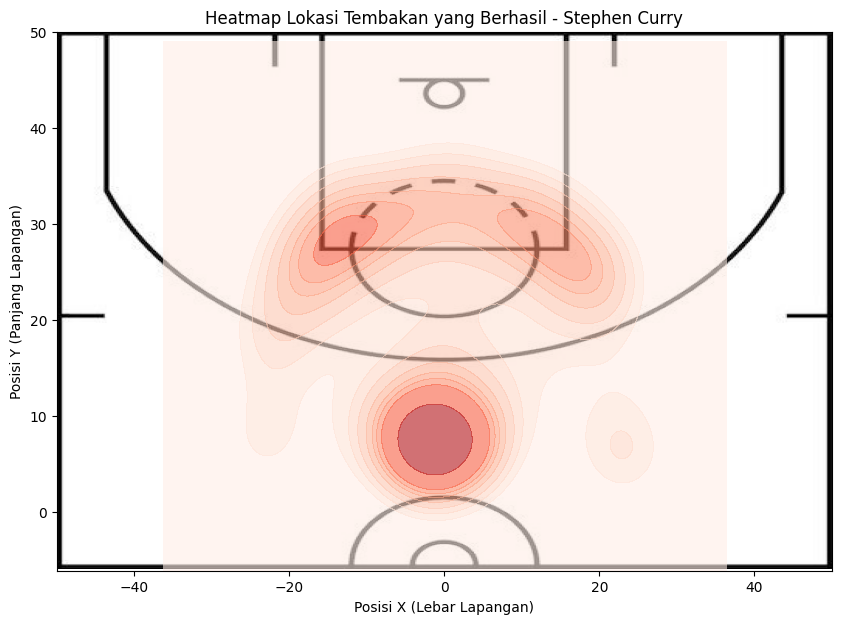

In [13]:
# Heatmap posisi shot terbaik
# Load gambar lapangan basket (pastikan file ini ada di direktori kerja)
court_img = mpimg.imread('basket_court.jpg')

# Ukuran lapangan NBA: Lebar -50 hingga 50, Panjang 0 hingga 47
court_width = 50
court_height = 50

# Buat plot
fig, ax = plt.subplots(figsize=(10, 7))

# Tampilkan gambar lapangan sebagai background
ax.imshow(court_img, extent=[-court_width, court_width, -6, court_height], aspect='auto')

# Filter data hanya untuk tembakan masuk dari Stephen Curry
made_shots = df[(df['player_name'] == 'Stephen Curry') & (df['shot_made'] == 1)]

# Tambahkan heatmap
sns.kdeplot(x=made_shots['loc_x'], y=made_shots['loc_y'], cmap="Reds", fill=True, thresh=0, alpha=0.6)

# Tambahkan label dan judul
ax.set_title("Heatmap Lokasi Tembakan yang Berhasil - Stephen Curry")
ax.set_xlabel("Posisi X (Lebar Lapangan)")
ax.set_ylabel("Posisi Y (Panjang Lapangan)")

# Tampilkan plot
plt.show()

Dari piechart yang dibuat menunjukkan kalau Stephen curry lebih banyak mencetak 3pt dari pada 2pt dan dari heat map kita bisa lihat kalau posisi shot curry terbaik berada di bagian tengah 3pt field

## B. Berapa rata-rata point yang di raik oleh lebron james per game dan Tipe shot seperti apa yang sering digunakan oleh lebron james untuk mencetak point?

In [14]:
# Rata-rata point lebron james per game
lj_avg = df[df['player_name'] == 'LeBron James'].groupby('game_id')['shot_type'].count().mean()

print(f'Rata-rata point per game Lebron James: {lj_avg}')

Rata-rata point per game Lebron James: 17.87323943661972


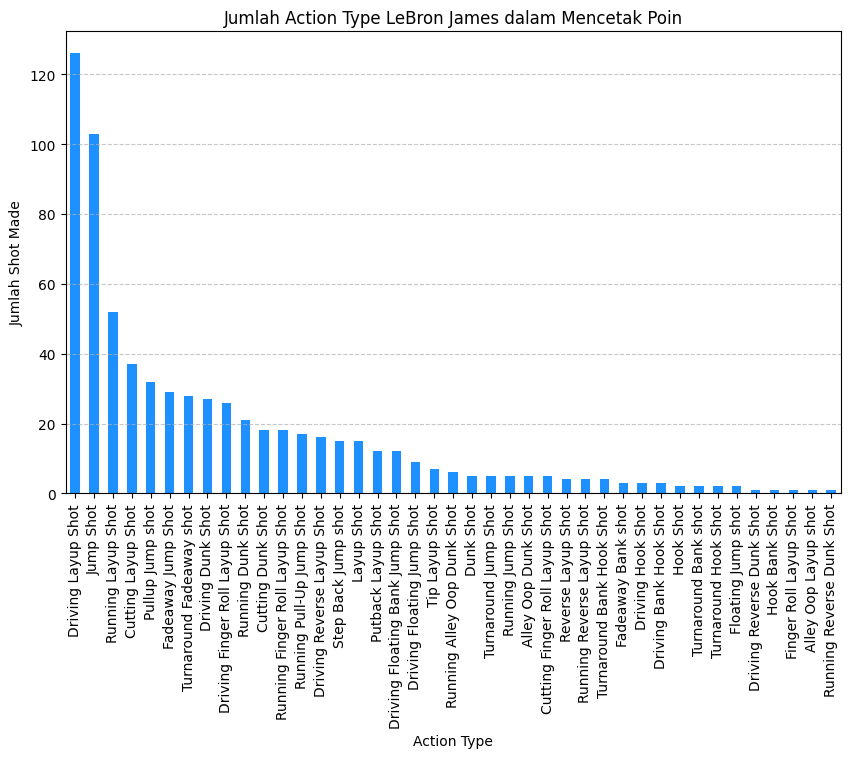

In [15]:
# Best action_type lebron james dalam mencetak point
lj_shot = df[(df['player_name'] == 'LeBron James') & (df['shot_made'] == 1)]['action_type'].value_counts()

# Buat bar chart
plt.figure(figsize=(10, 6))
lj_shot.plot(kind='bar', color='dodgerblue')

plt.title("Jumlah Action Type LeBron James dalam Mencetak Poin")
plt.xlabel("Action Type")
plt.ylabel("Jumlah Shot Made")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Dari hasil di atas kita bisa menarik kesimpulan kalau Lebron James dalam 1 game rata-rata point yang dia buat adalah 18 dan jenis shot yang sering mendapatkan point adalah driving layup dan jump shot

## 4. Feature Engineering

Karena data berjumlah ratusan ribu saya akan mengambil 20 ribu data saja berdasarkan tanggal terbaru 

In [16]:
dfn = df.sort_values(by='game_date', ascending=False).head(20000)
dfn

,season_1,season_2,team_id,team_name,player_id,player_name,position_group,position,game_date,game_id,...,basic_zone,zone_name,zone_abb,zone_range,loc_x,loc_y,shot_distance,quarter,mins_left,secs_left
101497,2024,2023-24,1610612749,Milwaukee Bucks,201976,Patrick Beverley,G,PG,2024-12-04,22301179,...,Restricted Area,Center,C,Less Than 8 ft.,-0.5,7.25,2,2,11,12
152559,2024,2023-24,1610612744,Golden State Warriors,1631218,Trayce Jackson-Davis,F,PF,2024-12-04,22301182,...,Restricted Area,Center,C,Less Than 8 ft.,2.5,4.25,2,1,10,24
58568,2024,2023-24,1610612755,Philadelphia 76ers,1630178,Tyrese Maxey,G,PG,2024-12-04,22301171,...,Restricted Area,Center,C,Less Than 8 ft.,-0.2,6.45,1,4,10,10
58569,2024,2023-24,1610612755,Philadelphia 76ers,1627741,Buddy Hield,F,SF-SG,2024-12-04,22301171,...,Above the Break 3,Left Side Center,LC,24+ ft.,10.3,30.35,27,4,9,34
58570,2024,2023-24,1610612755,Philadelphia 76ers,1630178,Tyrese Maxey,G,PG,2024-12-04,22301171,...,Mid-Range,Left Side Center,LC,16-24 ft.,6.4,20.45,16,4,8,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173022,2024,2023-24,1610612742,Dallas Mavericks,1630182,Josh Green,G,SG,2024-09-03,22300919,...,In The Paint (Non-RA),Center,C,Less Than 8 ft.,-4.0,8.45,5,1,1,36
173021,2024,2023-24,1610612742,Dallas Mavericks,202681,Kyrie Irving,G,SG,2024-09-03,22300919,...,Mid-Range,Left Side Center,LC,16-24 ft.,8.7,19.35,16,1,1,56
173020,2024,2023-24,1610612742,Dallas Mavericks,202681,Kyrie Irving,G,SG,2024-09-03,22300919,...,Right Corner 3,Right Side,R,24+ ft.,-22.4,6.35,22,1,2,50
173019,2024,2023-24,1610612742,Dallas Mavericks,1628467,Maxi Kleber,C,C,2024-09-03,22300919,...,Above the Break 3,Center,C,24+ ft.,-4.7,31.05,26,1,3,18


Karena game_date bertipe datetime saya akan ekstraksi kolom menjadi 3 bagian year,month,dan day untuk mempermudah modeling, dan untuk kolom game_date akan saya drop

In [17]:
# Ekstraksi fitur waktu
dfn["game_year"] = dfn["game_date"].dt.year
dfn["game_month"] = dfn["game_date"].dt.month
dfn["game_day"] = dfn["game_date"].dt.day

# drop kolom game_date
dfn.drop(columns='game_date',inplace=True)

### A. Split Between X dan y

In [18]:
# Memisahkan kolom fitur dengan target
X = dfn.drop(['shot_made'], axis=1)
y = dfn.shot_made

X

,season_1,season_2,team_id,team_name,player_id,player_name,position_group,position,game_id,home_team,...,zone_range,loc_x,loc_y,shot_distance,quarter,mins_left,secs_left,game_year,game_month,game_day
101497,2024,2023-24,1610612749,Milwaukee Bucks,201976,Patrick Beverley,G,PG,22301179,OKC,...,Less Than 8 ft.,-0.5,7.25,2,2,11,12,2024,12,4
152559,2024,2023-24,1610612744,Golden State Warriors,1631218,Trayce Jackson-Davis,F,PF,22301182,GSW,...,Less Than 8 ft.,2.5,4.25,2,1,10,24,2024,12,4
58568,2024,2023-24,1610612755,Philadelphia 76ers,1630178,Tyrese Maxey,G,PG,22301171,PHI,...,Less Than 8 ft.,-0.2,6.45,1,4,10,10,2024,12,4
58569,2024,2023-24,1610612755,Philadelphia 76ers,1627741,Buddy Hield,F,SF-SG,22301171,PHI,...,24+ ft.,10.3,30.35,27,4,9,34,2024,12,4
58570,2024,2023-24,1610612755,Philadelphia 76ers,1630178,Tyrese Maxey,G,PG,22301171,PHI,...,16-24 ft.,6.4,20.45,16,4,8,51,2024,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173022,2024,2023-24,1610612742,Dallas Mavericks,1630182,Josh Green,G,SG,22300919,DET,...,Less Than 8 ft.,-4.0,8.45,5,1,1,36,2024,9,3
173021,2024,2023-24,1610612742,Dallas Mavericks,202681,Kyrie Irving,G,SG,22300919,DET,...,16-24 ft.,8.7,19.35,16,1,1,56,2024,9,3
173020,2024,2023-24,1610612742,Dallas Mavericks,202681,Kyrie Irving,G,SG,22300919,DET,...,24+ ft.,-22.4,6.35,22,1,2,50,2024,9,3
173019,2024,2023-24,1610612742,Dallas Mavericks,1628467,Maxi Kleber,C,C,22300919,DET,...,24+ ft.,-4.7,31.05,26,1,3,18,2024,9,3


In [19]:
# Merubah Falue di kolom y 
y = y.replace({True: 1, False: 0})


C:\Users\rifat\AppData\Local\Temp\ipykernel_14988\495706648.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({True: 1, False: 0})


### B. Feature Selection

Saya akan menghapus kolom yang menurut saya isi dari kolom tersebut memiliki value yang sama dengan kolom lain atau dapat mempersulit model mempelajari data seperti:

- kolom season_1 dan season_2 akan saya hapus karena jika ada data yang diluar tahun yang terdapat di data model akan kesulitan karena belum pernah mempelajarinya

- kolom team_id karena sudah ada kolom team_name, kolom player_id karena sudah ada player_name, dan kolom position karena sudah ada position_group yang memiliki cardinality lebih kecil

- kolom event_type karena sudah ada kolom shot-made yang digunakan sebagai target

- kolom basic_zone, dan zone_abb, karena valuenya sama dengan kolom zone_name

In [20]:
# Drop kolom
X = X.drop(columns=['season_1','season_2','game_id','team_id','player_id','position','event_type','basic_zone','zone_abb'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 101497 to 173018
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   team_name       20000 non-null  object 
 1   player_name     20000 non-null  object 
 2   position_group  20000 non-null  object 
 3   home_team       20000 non-null  object 
 4   away_team       20000 non-null  object 
 5   action_type     20000 non-null  object 
 6   shot_type       20000 non-null  int64  
 7   zone_name       20000 non-null  object 
 8   zone_range      20000 non-null  object 
 9   loc_x           20000 non-null  float64
 10  loc_y           20000 non-null  float64
 11  shot_distance   20000 non-null  int64  
 12  quarter         20000 non-null  int64  
 13  mins_left       20000 non-null  int64  
 14  secs_left       20000 non-null  int64  
 15  game_year       20000 non-null  int32  
 16  game_month      20000 non-null  int32  
 17  game_day        20000 non-null

Karena cardinalitynya sudah kecil saya akan lanjut memisahkan kolom berdasarkan tipenya

In [21]:

# menyimpan nama kolom yang numerik, categorical, encoded,  dan date
num = ['loc_x', 'loc_y','shot_distance','quarter', 'mins_left','secs_left']
cat_nom = ['team_name', 'player_name', 'position_group','home_team','away_team','action_type','shot_type','zone_name']
cat_ord = ['zone_range']



### C Train Test Split

In [22]:
# Splitting data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
print('Train Size: ', X_train.shape) # menampilkan dimensi data
print('Test Size: ', X_test.shape) # menampilkan dimensi data

Train Size:  (16000, 18)
Test Size:  (4000, 18)


Karena tidak ada missing value saya akan lanjut ke outlier handling

### D. Handling Outlier

Untuk kolom numerical akan saya cek nilai skewnya

In [23]:
# cek nilai skew
for i in X_train[num]:
    print(f'{i} nilai skew: {X_train[i].skew()}')

loc_x nilai skew: 0.010552371672149596
loc_y nilai skew: 0.7795960260131819
shot_distance nilai skew: 0.13247225259618642
quarter nilai skew: 0.06559968039112035
mins_left nilai skew: 0.005683418263014372
secs_left nilai skew: 0.008129174321557082


Dari data diatas yang memiliki nilai skew (>0.5) hanya kolom loc_y dan yang lainnya terdistribusi normal, untuk yang terdistribusi normal saya akan handling dengan Winsorizer dengan metode gaussian dan yang skew akan menggunakan metode IQR

In [24]:
# mencari low dan up bound dari kolom yang terdistribusi normal
def find_bound_gauss(table, var):
    mean = table[var].mean()  # Rata-rata
    std = table[var].std()  # Standar deviasi

    low_bound = mean - 3 * std  # Lower bound
    up_bound = mean + 3 * std  # Upper bound

    return up_bound, low_bound

# Nilai low dan up bound untuk beberapa kolom
for i in ['loc_x', 'shot_distance', 'quarter', 'mins_left', 'secs_left']:
    up_bounds, low_bounds = find_bound_gauss(X_train, i)
    print(f'up bound {i}: {up_bounds}, low bound {i}: {low_bounds}')

up bound loc_x: 34.54651307682736, low bound loc_x: -34.48463807682736
up bound shot_distance: 45.30973199209045, low bound shot_distance: -18.066481992090445
up bound quarter: 5.876670695988557, low bound quarter: -0.9071706959885573
up bound mins_left: 15.70175642676199, low bound mins_left: -4.960006426761991
up bound secs_left: 81.24176032429114, low bound secs_left: -23.64163532429114


In [25]:
# Handling outlier kolom yang terdistribusi normal
winsor_gauss = Winsorizer(capping_method= 'gaussian',
                          tail = 'both',
                          fold=3,
                          variables=['loc_x','shot_distance','quarter', 'mins_left','secs_left'])
X_train_capping = winsor_gauss.fit_transform(X_train)
X_test_capping = winsor_gauss.transform(X_test)

In [26]:
# mencari up dan low boundary kolom yang skew
def find_bound_iqr(table, variable):
    Q1 = table[variable].quantile(0.25)
    Q3 = table[variable].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Hitung batas bawah dan atas
    low_bound = Q1 - (IQR * 1.5)
    up_bound = Q3 + (IQR * 1.5)

    return up_bound, low_bound

# nilai low dan up bound kolom loc_y
up_bounds, low_bounds = find_bound_iqr(X_train,'loc_y')
print(f'up bound loc_y: {up_bounds}, low bound loc_y: {low_bounds}')

up bound loc_y: 48.400000000000006, low bound loc_y: -18.400000000000006


In [27]:
# Handling outlier untuk kolom yang skew
winsor_iqr = Winsorizer(capping_method='iqr',
                        tail='both',
                        fold=1.5,
                        variables=['loc_y'])
X_train_capping = winsor_iqr.fit_transform(X_train_capping)
X_test_capping = winsor_iqr.transform(X_test_capping)

Untuk feature encoding saya akan menggunakan ordinal encoder untuk kolom cat_ord, dan untuk kolom cat_nom saya akan gunakan one hot encoding, untuk feature scaling saya akan gunakan standard scaler karena rata-rata datanya terdistribusi normal, saya akan gunakan Column Transformer untuk mempermudah saat modeling dan model saving

In [28]:
# Define preprocess yang ingin dilakukan
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal = OrdinalEncoder(categories=[['Less Than 8 ft.','8-16 ft.','16-24 ft.','24+ ft.','Back Court Shot']])

# column transformer
preprocess = ColumnTransformer(
    transformers=[
        ('cat_nom',ohe,cat_nom),
        ('cat_ord',ordinal,cat_ord),
        ('num',scaler,num)], 
    remainder='passthrough'
)

Saya membuat collumn transformer untuk data inference karena saya hanya akan memasukkan 1 data sehingga tidak perlu dilakukan handling outlier

## 5. Modeling

Saya akan mencari model terbaik untuk menangani case ini, diantara model KNeighborsClassifier, SVC, DecisionTree Classifiee, RandomForest Classifier, dan XGB Classifier. Saya akan membuat pipelinenya terlebih dahulu

### A. Membuat Pipeline

In [29]:
# Membuat Pipeline
pipe_knc = make_pipeline(preprocess, KNeighborsClassifier())
pipe_svc = make_pipeline(preprocess, SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced'))
pipe_dt = make_pipeline(preprocess, DecisionTreeClassifier())
pipe_rf = make_pipeline(preprocess, RandomForestClassifier())
pipe_xgb = make_pipeline(preprocess, XGBClassifier(eval_metric='logloss'))

Selanjutnya saya akan melihat apakah data imbalance atau tidak

In [30]:
# Melihat apakah data train seimbang atau tidak
y_test.value_counts()

shot_made
0    2099
1    1901
Name: count, dtype: int64

Dari hasil di atas terdapat perbedaan sebesar 11.68%, dan saya menyimpulkan kalau data imbalance sehingga saya akan menggunakan skfold dengan n_split=5 dalam proses cross validation

untuk scoring saya akan mengacu pada nilai recall karena saya ingin meminimalisir False Negative

### B. Cross Validation

In [31]:
# Setting skfold
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=50)

# Membuat cross validation
cv_knc = cross_val_score(pipe_knc, X_train_capping, y_train, cv = skfold, scoring= 'recall', n_jobs=-1)
cv_svc = cross_val_score(pipe_svc, X_train_capping, y_train, cv = skfold, scoring= 'recall', n_jobs=-1)
cv_dt = cross_val_score(pipe_dt, X_train_capping, y_train, cv = skfold, scoring= 'recall', n_jobs=-1)
cv_rf = cross_val_score(pipe_rf, X_train_capping, y_train, cv = skfold, scoring= 'recall', n_jobs=-1)
cv_xgb = cross_val_score(pipe_xgb, X_train_capping, y_train, cv = skfold, scoring= 'recall', n_jobs=-1)

In [32]:
# Finding Best Model based on Cross_Val_Score (mean)
name_model = []
cv_scores = 0
for cv,name in zip([cv_knc,cv_svc,cv_dt,cv_rf,cv_xgb],
                   ['knc_model','svc_model','dt_model','rf_model','xgb_model']):
  print(name)
  print('recall - All - Cross Validation :', cv)
  print('recall - Mean - Cross Validation :', cv.mean())
  print('recall - std - Cross Validation :', cv.std())
  print('recall - Range of Test Set :', (cv.mean()-cv.std()), '-' , (cv.mean()+cv.std()))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_scores)

knc_model
recall - All - Cross Validation : [0.55003313 0.50563287 0.52320955 0.50464191 0.54376658]
recall - Mean - Cross Validation : 0.5254568082222842
recall - std - Cross Validation : 0.018817769320041606
recall - Range of Test Set : 0.5066390389022426 - 0.5442745775423259
--------------------------------------------------
svc_model
recall - All - Cross Validation : [0.5526839  0.51822399 0.53381963 0.52254642 0.55503979]
recall - Mean - Cross Validation : 0.5364627443121993
recall - std - Cross Validation : 0.01510982908990524
recall - Range of Test Set : 0.5213529152222941 - 0.5515725734021045
--------------------------------------------------
dt_model
recall - All - Cross Validation : [0.57985421 0.53943009 0.53249337 0.52188329 0.54177719]
recall - Mean - Cross Validation : 0.5430876280776877
recall - std - Cross Validation : 0.019640461261902564
recall - Range of Test Set : 0.5234471668157852 - 0.5627280893395903
--------------------------------------------------
rf_model
rec

Dari hasil Cross validation diatas kita mendapatkan best modelnya dengan model decision tree karena nilai recall meannya paling besar 0.5426 dan untuk nilai standar deviasinya juga terkecil, semakini kecil nilai standar deviasi maka model semakin konsisten, maka dari itu saya memutuskan untuk mengguanakn model decision tree 

### C. Train Model & Model Predict 

In [33]:
# Fit pipeline model Decision Tree dengan data train
pipe_dt.fit(X_train_capping,y_train)

c:\Users\rifat\anaconda3\envs\py39\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_nom',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['team_name', 'player_name',
                                                   'position_group',
                                                   'home_team', 'away_team',
                                                   'action_type', 'shot_type',
                                                   'zone_name']),
                                                 ('cat_ord',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'Than '
                                                                              '8 '
                                                                              'ft.',
                                                                              '8-16 '
                                                                              'ft.',
                                                                              '16-24 '
                                                                              'ft.',
                                                                              '24+ '
                                                                              'ft.',
                                                                              'Back '
                                                                              'Court '
                                                                              'Shot']]),
                                                  ['zone_range']),
                                                 ('num', StandardScaler(),
                                                  ['loc_x', 'loc_y',
                                                   'shot_distance', 'quarter',
                                                   'mins_left',
                                                   'secs_left'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [34]:
# Predict data train dan test
y_pred_train = pipe_dt.predict(X_train_capping)
y_pred_test = pipe_dt.predict(X_test_capping)

### D. Model Evaluation Sebelum Tuning

In [35]:
# Print recall score
print(f'Recall Score Train set: {recall_score(y_train,y_pred_train)}')
print(f'Recall Score Test set: {recall_score(y_test, y_pred_test)}')

Recall Score Train set: 1.0
Recall Score Test set: 0.5144660704892162


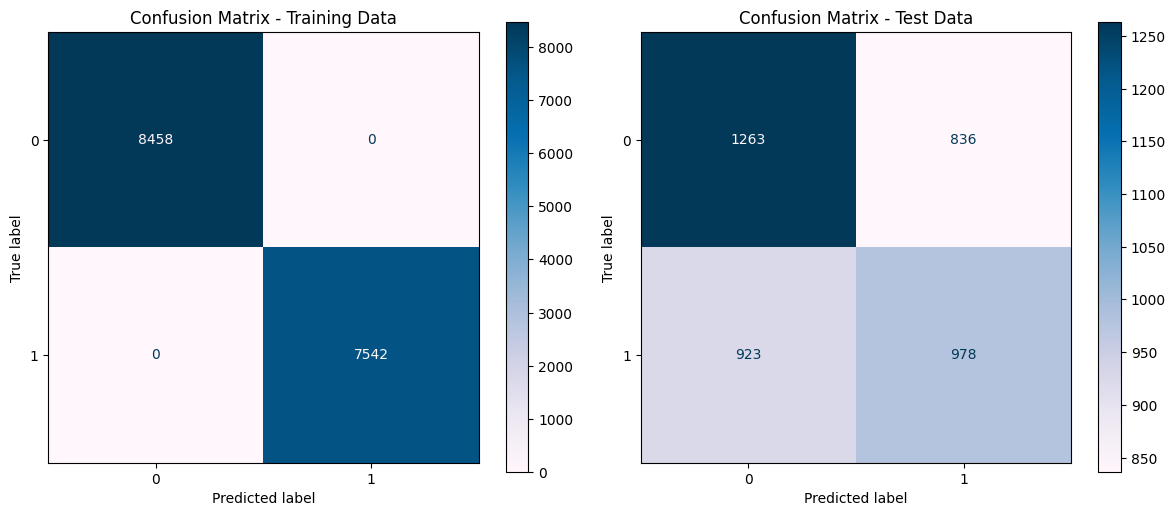

In [36]:
# Membuat confusion matrix dari model KNC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_matrix = ConfusionMatrixDisplay.from_estimator(pipe_dt, X_train_capping, y_train, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

test_matrix = ConfusionMatrixDisplay.from_estimator(pipe_dt, X_test_capping, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Dari hasil recall score dari data train dan test menunjukkan bahwa model sangat overfitting, karena model terlalu menyesuaikan diri dengan data train sehingga kurang bisa memprediksi data test, maka dari itu saya akan melakukan hyperparameter tuning dengan metode Random Search agar proses running lebih cepat

In [37]:
# Menyimpan hasil model tanpa hyperparameter tuning
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
    score_reports = {
        'Recall Train Set': recall_score(y_train, y_pred_train),
        'Recall Test Set': recall_score(y_test, y_pred_test),
    }

    # menghitung confusion matrix data train dan test
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    score_reports['False Negative Train'] = cm_train[1, 0]
    score_reports['False Negative Test'] = cm_test[1, 0]
    all_reports[name] = score_reports
    return all_reports

all_reports = {}
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Decision Tree tanpa Tuning')

pd.DataFrame(all_reports)

,Decision Tree tanpa Tuning
Recall Train Set,1.000000
Recall Test Set,0.514466
False Negative Train,0.000000
False Negative Test,923.000000


### E. Hyperparameter Tuning

In [38]:

# Define parameter yang ingin digunuakan
random_param = {
    'decisiontreeclassifier__criterion':['gini', 'entropy'],
    'decisiontreeclassifier__splitter' : ['best', 'random'],
    'decisiontreeclassifier__max_depth' : [3,5,10,None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10,20],
    'decisiontreeclassifier__min_samples_leaf': [1, 5, 10,20],
    'decisiontreeclassifier__class_weight': [None, 'balanced'],
    'decisiontreeclassifier__ccp_alpha' : [0.001, 0.01, 0.1],
    'decisiontreeclassifier__max_leaf_nodes': [10, 20, 50, None]
}


In [39]:
# Mencari best parameter dengan Random Search
random_dt = RandomizedSearchCV(estimator= pipe_dt,
                                param_distributions= random_param,
                                n_iter=5,
                                cv= skfold,
                                n_jobs= -1,
                                scoring='recall',
                                error_score='raise')
random_dt.fit(X_train,y_train)

c:\Users\rifat\anaconda3\envs\py39\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_nom',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['team_name',
                                                                                'player_name',
                                                                                'position_group',
                                                                                'home_team',
                                                                                'away_team',
                                                                                'action_ty...
                                                                                 'balanced'],
                                        'decisiontreeclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'decisiontreeclassifier__max_depth': [3,
                                                                              5,
                                                                              10,
                                                                              None],
                                        'decisiontreeclassifier__max_leaf_nodes': [10,
                                                                                   20,
                                                                                   50,
                                                                                   None],
                                        'decisiontreeclassifier__min_samples_leaf': [1,
                                                                                     5,
                                                                                     10,
                                                                                     20],
                                        'decisiontreeclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10,
                                                                                      20],
                                        'decisiontreeclassifier__splitter': ['best',
                                                                             'random']},
                   scoring='recall')

In [40]:
# Best parameter model Decision Tree
print('Best hyperparameters for Decision Tree:', random_dt.best_params_)

# Menyimpan best parameter Decision Tree
best_dt_model = random_dt.best_estimator_

Best hyperparameters for Decision Tree: {'decisiontreeclassifier__splitter': 'random', 'decisiontreeclassifier__min_samples_split': 20, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_leaf_nodes': 50, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__ccp_alpha': 0.01}


Kita sudah mendapatkan parameter terbaik untuk model Decision Tree selanjutnya kita akan evaluasi

### F. Model Evaluation Setelah Tuning

In [41]:
# Model predict dengan best_dt_model
y_pred_train_best = best_dt_model.predict(X_train_capping)
y_pred_test_best = best_dt_model.predict(X_test_capping)

In [42]:
# Print recall score
print(f'Recall Score Train set: {recall_score(y_train,y_pred_train_best)}')
print(f'Recall Score Test set: {recall_score(y_test, y_pred_test_best)}')

Recall Score Train set: 0.43145054362238133
Recall Score Test set: 0.41083640189374016


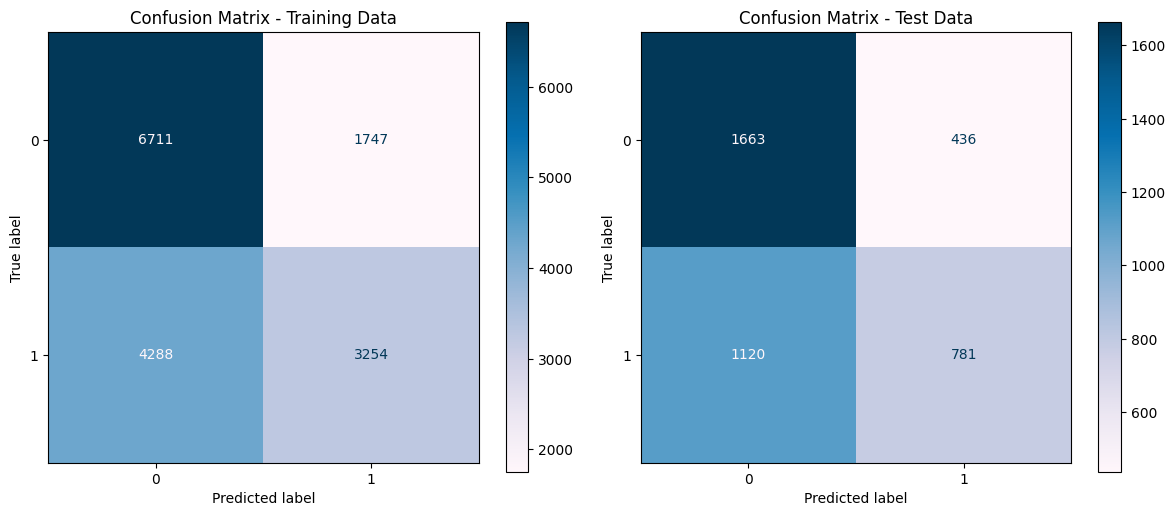

In [43]:
# Membuat confusion matrix dari best model decision tree
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_matrix_best = ConfusionMatrixDisplay.from_estimator(best_dt_model, X_train_capping, y_train, cmap='PuBu', ax=axes[0])
train_matrix_best.ax_.set_title('Confusion Matrix - Training Data')

test_matrix_best = ConfusionMatrixDisplay.from_estimator(best_dt_model, X_test_capping, y_test, cmap='PuBu', ax=axes[1])
test_matrix_best.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Dari tuning recall score mengalami penurunan menjadi 0.523, tetapi model termasuk good fit karena recall score di test setnya 0.5139

In [44]:
# Menambahkan hasil untuk membandingkan dengan sebelum hyper parameter
all_reports = performance_report(all_reports, y_train, y_pred_train_best, y_test, y_pred_test_best, 'Decision Tree dengan Tuning')
pd.DataFrame(all_reports)

,Decision Tree tanpa Tuning,Decision Tree dengan Tuning
Recall Train Set,1.000000,0.431451
Recall Test Set,0.514466,0.410836
False Negative Train,0.000000,4288.000000
False Negative Test,923.000000,1120.000000


Dari tabel diatas kita bisa menyimpulkan bahwa model setelah tuning termasuk kedalam Good Fit meskipun persentasenya kecil, dan meskipun model sebelum tuning memiliki recall score maksimal yaitu 1, tetapi recall score test setnya berbeda jauh ini menunjukkan bahwa model sangat over fit. kita juga bisa melihat bahwa model sebelum tuning memiliki keunggulan dalam memprediksi data train tetapi dari hasil data test yang kecil menunjukkan bahwa model terlalu menyesuaikan dengan data train sehingga menyebabkan data overfit, dalam model setelah tuning memiliki kelebihan recall score yang good fit tidak seperti model sebelum tuning, tetapi persentasenya cukup kecil hanya di kisaran 52% ini menunjukkan kalau model masih melewatkan cukup banyak true positive. Kedepannya mungkin bisa menambahkan datanya untuk meningkatkan variasi data atau bisa dicoba dengan parameter yang lain, maka dari itu untuk model inference dan deploy saya akan menggunakan model setelah tuning

## 6. Model Saving

In [45]:
# menyimpan model
with open('model_dt.pkl', 'wb') as model_file:
  pickle.dump(best_dt_model, model_file)

## 7. Model Inference

Untuk model inference akan saya lakukan di file notebook dengan nama 'ML_NBA_Players_Shot_Made_Pred_Inf.ipynb'

## 8. Kesimpulan

Dalam pembuatan machine learning ini saya ingin mencari model terbaik yang cocok untuk menangani dataset yang saya punnya, kandidat modelnya adalah KNC, SVC, Decision Tree, Random Forest, dan XGboost. Data set yang saya miliki tidak memiliki missing value, untuk preprocess saya menggunakan column transformer untuk mempermudah dalam model saving dan pembuatan pipeline, setelah pipeline dibuat saya melakukan cross validation untuk mencari model terbaik dari 5 kandidat model yang sudah saya tentukan.

Hasil crossval menunjukkan bahwa model yang memeiliki nilai mean tertinggi adalah Decision Tree dan nilai standar deviasinya juga decision tree terkecil, maka dari itu saya memutuskan menggunakan model Decision Tree. Setelah predict data dengan model Decision Tree ternyata model terlalu menyesuaikan diri dengan data train sehingga membuat model sangat overfit, untuk mengurangi over fit ini saya menerapkan hyper parameter tuning untuk model decision tree.

Dan dari hasil setelah dilakukan tuning pada model Decision tree ternyata model menunjukkan Good Fit tetapi persentasi recall scorenya tidak besar hanya di kisaran 52% saja. Kedepannya mungkin kita bisa menambahkan data yang digunuakan untuk meningkatkan variasi data atau mencoba parameter tuning yang lain, karena hasilnya yang good fit saya memutuskan untuk melakukan model inference dan deploy dengan model setelah tuning

Model inference yang saya lakukan pada notebook 'nama' model memprediksi bahwa shot yang dilakukan oleh Luka Doncic Missed Shot atau tidak masuk